In [2]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [31]:
date = "27_02_2023"
fly = "EPG_GCaMP7f_EL_CsChrimsontdT_fly1"
session = "acute_bump_movement-009"
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=2)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

In [32]:
f = h5py.File(h5name)
data = f['/data'][:]



In [33]:
data.shape

(2, 4176, 8, 196, 240)

In [34]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)


In [35]:
shifts.shape

(2, 4176, 8)

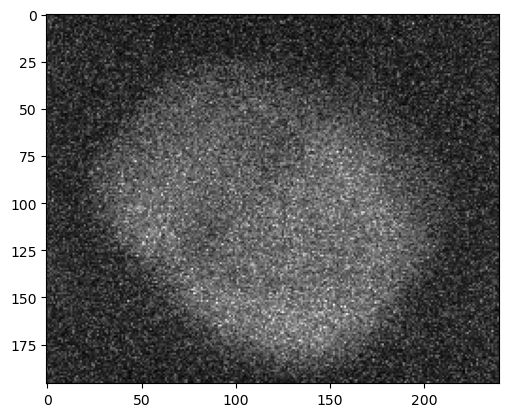

In [36]:
fig, ax = plt.subplots()
ax.imshow(ref_img[0,:,:,:].max(axis=0), cmap='Greys_r')

In [37]:
ref_img_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, ref_img)


In [11]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(ref_img)

In [51]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'

In [52]:
import cloudpickle
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']

In [13]:

eb_napari.make_phase_masks()
masks = eb_napari.masks

In [14]:

eb_napari.save_layers(napari_outputs_file)

In [13]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari.open_existing_session(napari_outputs_file)
# eb_napari.make_phase_masks()


In [46]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [47]:
df.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2'],
      dtype='object')

In [48]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [49]:
df_aligned.head()

,Time(ms),Start Trigger,Opto Trigger,FicTrac Cam Exp.,FicTrac Frame Proc.,Heading,Y/Index,Arena DAC1,Arena DAC2,Heading_cartx,Heading_carty,Y/Index_cartx,Y/Index_carty,Arena DAC1_cartx,Arena DAC1_carty,Arena DAC2_cartx,Arena DAC2_carty
0,58.291304,1.0,0.0,28.0,27.0,-2.180354,0.004218,-2.163138,-3.088154,-0.572504,-0.819901,0.999991,0.004218,-0.558304,-0.829633,-0.998569,-0.053413
1,174.873910,0.0,0.0,55.0,55.0,-2.152025,0.004027,-2.165838,-3.090029,-0.549051,-0.835789,0.999992,0.004027,-0.560541,-0.828122,-0.998668,-0.051541
2,291.456518,0.0,0.0,54.0,55.0,-2.177102,0.005077,-2.164230,-3.089087,-0.569836,-0.821759,0.999987,0.005077,-0.559211,-0.829025,-0.998622,-0.052481
3,408.039124,0.0,0.0,55.0,55.0,-2.180912,0.002326,-2.162630,-3.087962,-0.572962,-0.819582,0.999997,0.002326,-0.557884,-0.829919,-0.998562,-0.053605
4,524.621731,0.0,0.0,55.0,54.0,-2.151091,0.003468,-2.164598,-3.089413,-0.548270,-0.836301,0.999994,0.003468,-0.559516,-0.828819,-0.998639,-0.052156


In [53]:
print(masks.shape)

(8, 196, 240)


In [54]:
F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [55]:
# baseline
F_base = np.copy(F)
# smooth with a 1s gaussian
F_base = sp.ndimage.gaussian_filter1d(F_base,100,axis=-1)
F_base = np.percentile(F_base,10,axis=-1, keepdims=True)
# 10 s min max
# F_base = sp.ndimage.minimum_filter1d(F_base, 300, axis=-1)
# F_base = sp.ndimage.maximum_filter1d(F_base, 300, axis=-1)

In [56]:
print(F.shape)
print(notF.shape)

(2, 16, 4176)
(2, 4176)


In [57]:
data_corr.shape
notF = sp.ndimage.gaussian_filter1d(notF,3,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,3,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,.5,axis=1, mode='wrap')
# print(whole_frame_ts.shape)


In [58]:

# denom = F[0,:,:].mean(axis=1, keepdims=True).sum(axis=0,keepdims=True)
# f_denom = F[0,:,:].mean(axis=1,keepdims=True)/denom
# dff = F[1,:,:]/F_base[1,:,:]
# dff = sp.stats.zscore(dff,axis=-1)
# dff = 0*F[1,:,:]
# dff = sp.stats.zscore(F[0,:,:]-.*F[0,:,:].mean(axis=0,keepdims=True)-.0*whole_frame_ts[np.newaxis,:],axis=-1)
dff = sp.stats.zscore(F[1,:,:]-notF[1,np.newaxis,:],axis=-1)
# dff = sp.stats.zscore(F[0,:,:]-.7*whole_frame_ts[np.newaxis,:],axis=-1)


In [59]:
print(np.amin(dff),np.amax(dff))

-3.9813161180642327 5.329921128596152


In [60]:

x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])

_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))


# x_h, y_h = st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), heading)


rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
# rho,phi = st2p.utilities.cart2pol(sp.ndimage.median_filter(x_f.mean(axis=0),7),sp.ndimage.median_filter( y_f.mean(axis=0),7))
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
# _, offset = st2p.utilities.cart2pol(x_f.mean(axis=0)-x_h, y_f.mean(axis=0)-y_h)

# _, offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(offset.shape),offset-np.pi))

In [61]:
fig_folder = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/figs'
os.makedirs(fig_folder, exist_ok=True)

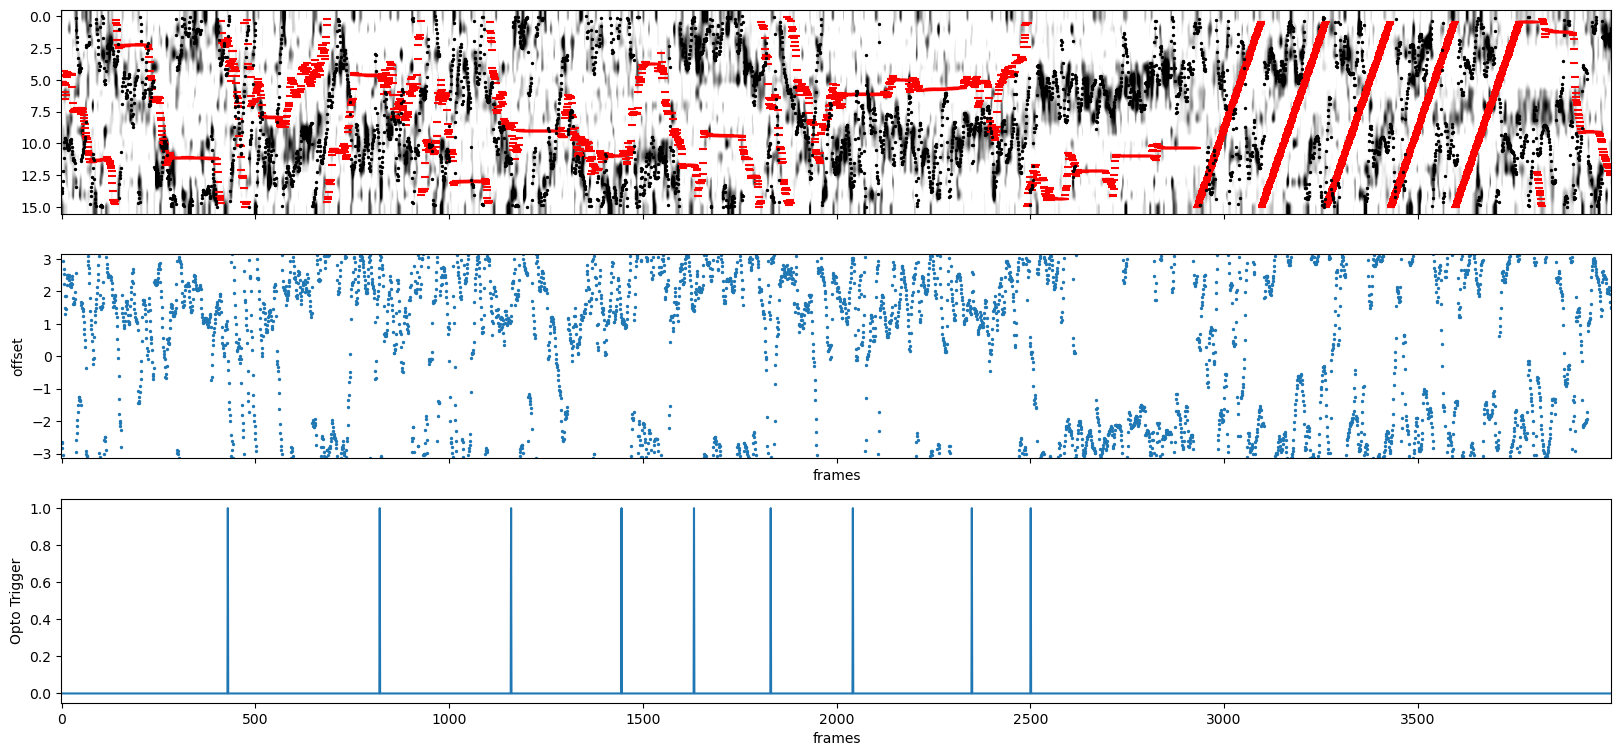

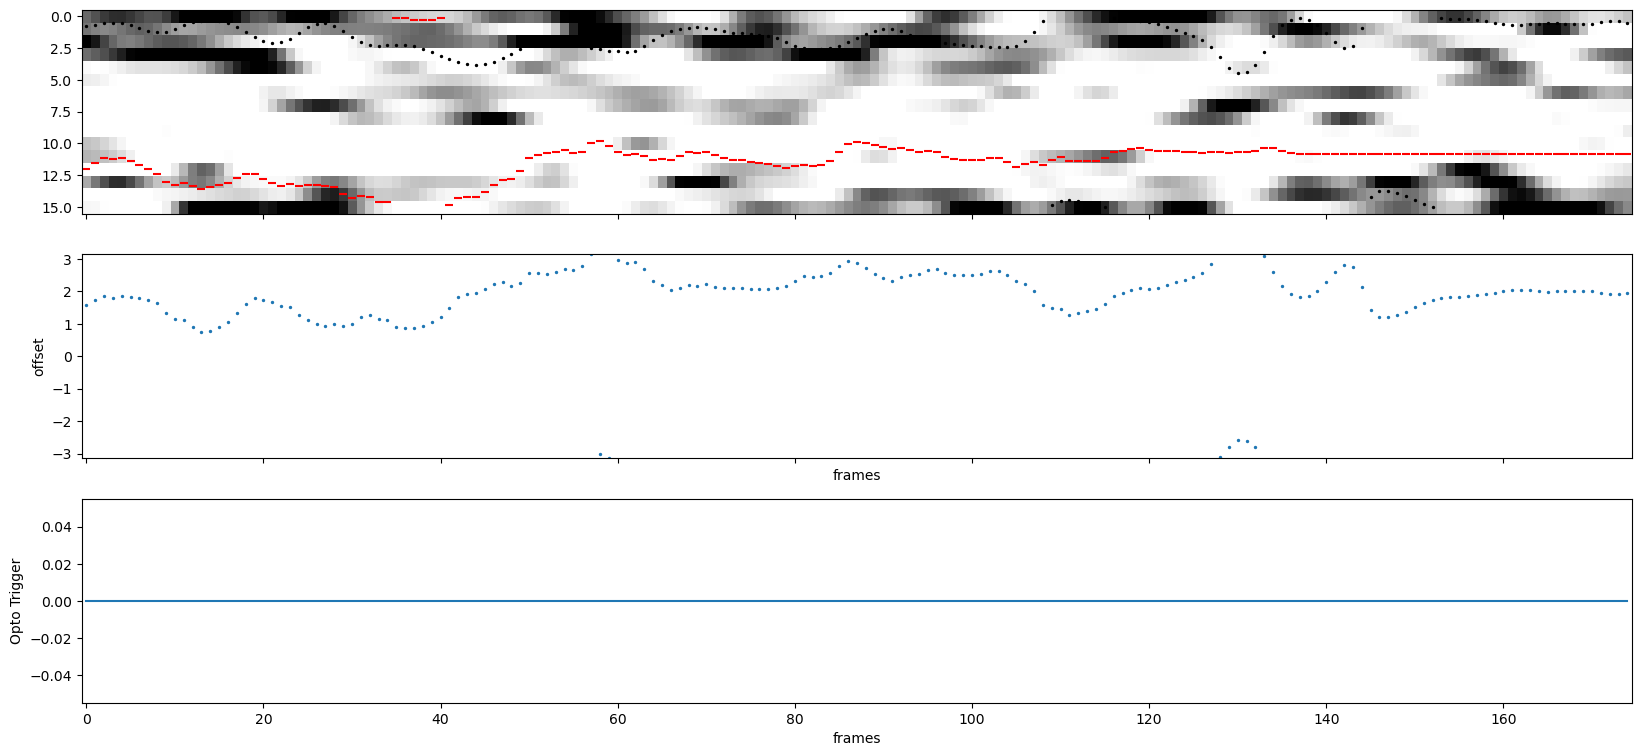

In [64]:
win_size = 4000

for num_fig, start_i in enumerate(range(0,dff.shape[-1]-3,win_size)):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots(3,1,figsize=[20,9], sharex=True)
    dff_window = dff[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Greys',vmin=0,vmax=2)
    x = np.arange(stop_i-start_i)
    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='_')
    
    ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='black', s=2)
    
    
    
    ax[1].scatter(x,offset[window],s=2)
    ax[1].set_ylim([-3.14,3.14])
    # ax[1].plot(x,0*offset[window], marker='_')
    ax[1].set_ylabel('offset')
    ax[1].set_xlabel('frames')
    
    ax[2].plot(x,df_aligned[' Opto Trigger'].iloc[window])
    ax[2].set_ylabel('Opto Trigger')
    ax[2].set_xlabel('frames')
    
    
    fig.savefig(os.path.join(fig_folder,f'offset_{num_fig}.jpg'))


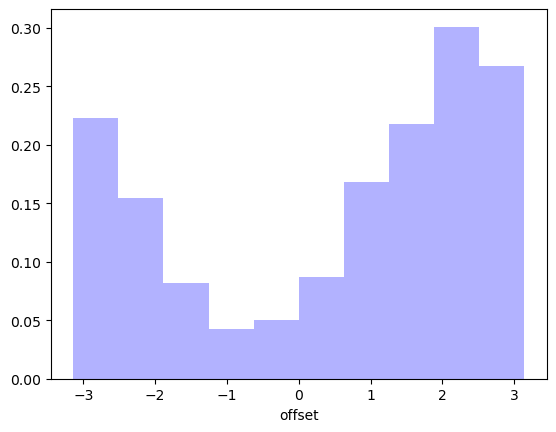

In [65]:
fig,ax = plt.subplots()
ax.hist(offset,alpha=.3, color='blue',density=True)
ax.set_xlabel('offset')
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

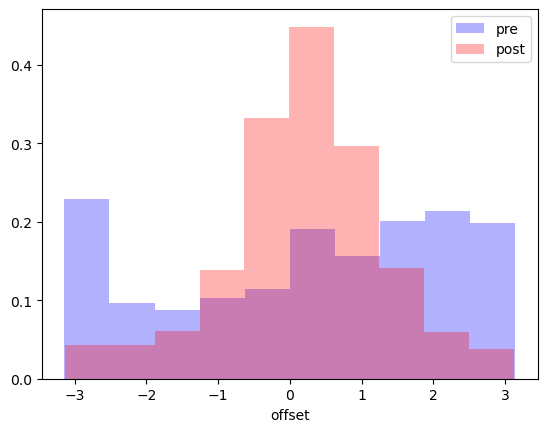

In [29]:
fig,ax = plt.subplots()
ax.hist(offset[:1300],alpha=.3, color='blue',density=True, label = 'pre')
ax.hist(offset[1700:],alpha=.3, color='red', density=True, label = 'post')
ax.set_xlabel('offset')
ax.legend()
fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

Text(0, 0.5, 'Phase offset')

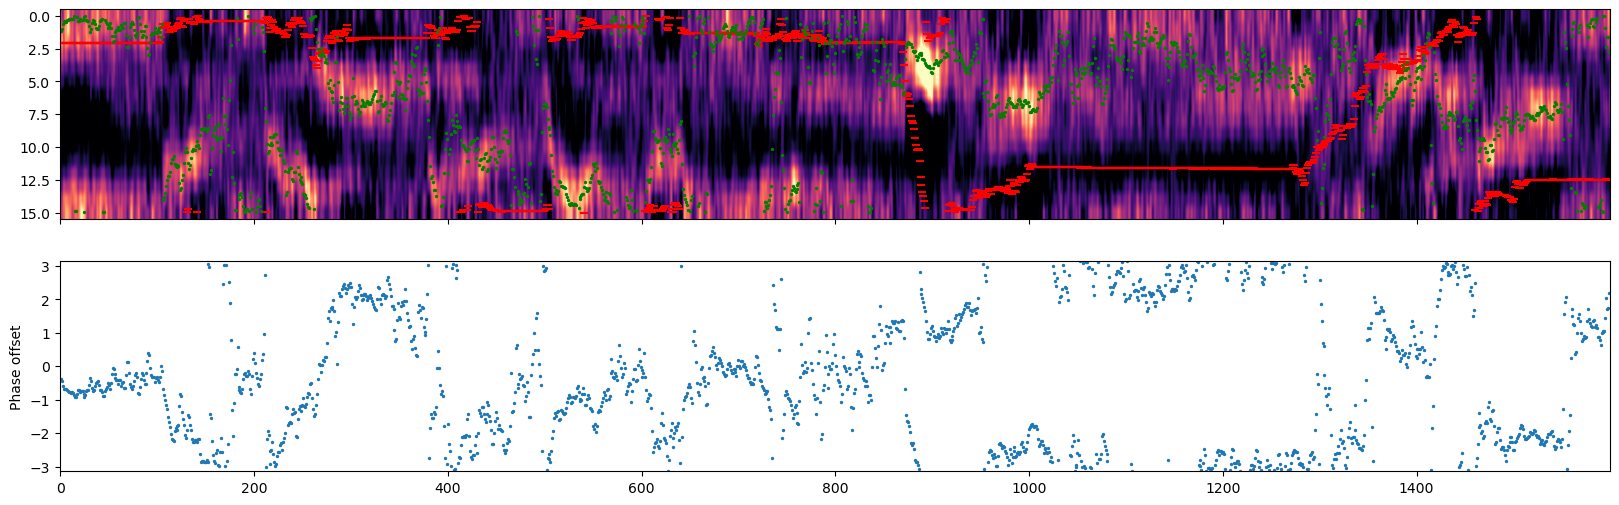

In [83]:
win = slice(600,2200)

fig,ax = plt.subplots(2,1, figsize=[20,6], sharex=True)
ax[0].imshow(dff[:,win], aspect='auto', cmap='magma', vmin=-1, vmax=3)
x = np.arange(0,2200-600)
ax[0].scatter(x, 15*(heading[win]+np.pi)/2/np.pi,color='red',marker='_')
ax[0].scatter(x,15*(phi[win]+np.pi)/2/np.pi,color='green', s=2)
ax[1].scatter(x,offset[win],s=2)
ax[1].set_ylim([-3.14,3.14])
ax[1].set_ylabel('Phase offset')

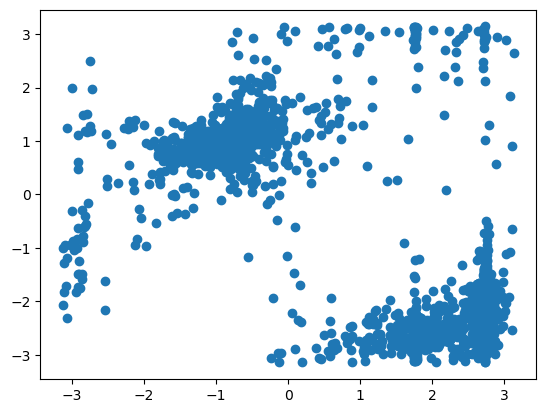

In [127]:
fig, ax = plt.subplots()
ax.scatter(heading[1600:-3],phi[1603:])


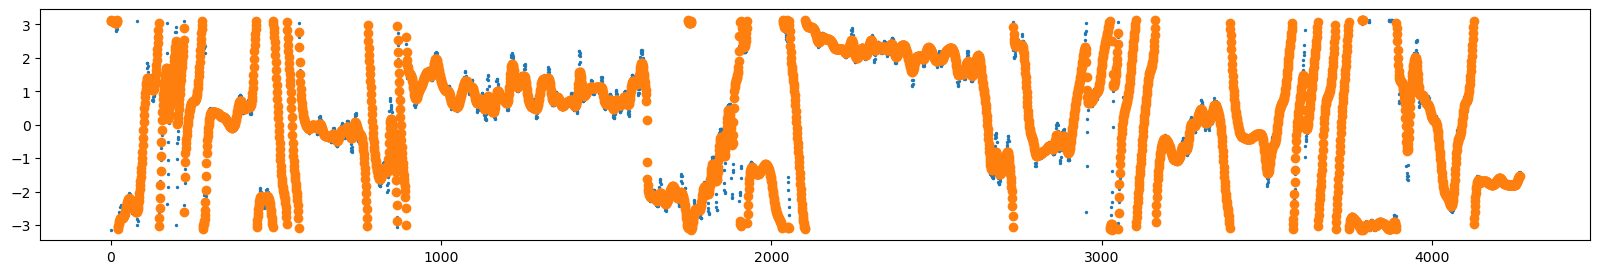

In [44]:
fig,ax = plt.subplots(figsize=[20,3])
ax.scatter(np.arange(offset.shape[0]),offset,s=2)
offset_cart_x, offset_cart_y = st2p.utilities.pol2cart(np.ones(offset.shape),offset)
_, offset_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(offset_cart_x,5),sp.ndimage.gaussian_filter1d(offset_cart_y,5))
ax.scatter(np.arange(offset.shape[0]), offset_sm)

(array([196., 162., 206., 278., 190., 186., 233., 323., 304., 478., 405.,
        320., 210., 404., 201., 170.]),
 array([-3.14068899e+00, -2.74813816e+00, -2.35558733e+00, -1.96303650e+00,
        -1.57048567e+00, -1.17793484e+00, -7.85384013e-01, -3.92833183e-01,
        -2.82353929e-04,  3.92268475e-01,  7.84819305e-01,  1.17737013e+00,
         1.56992096e+00,  1.96247179e+00,  2.35502262e+00,  2.74757345e+00,
         3.14012428e+00]),
 <BarContainer object of 16 artists>)

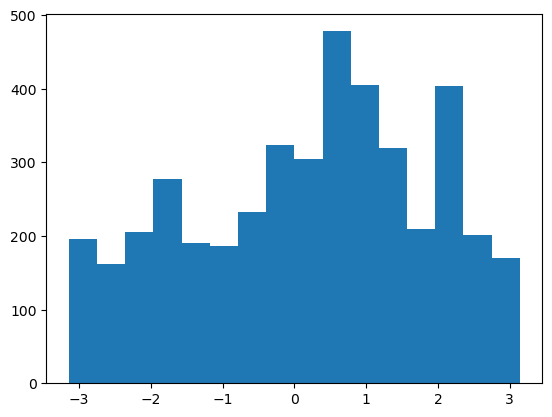

In [45]:
fig, ax = plt.subplots()
ax.hist(offset,bins=16)

In [11]:
data.shape

(2, 3280, 7, 208, 259)